# Flightpath characterization
In this notebook we look at the characterization of the flight path. Up until now we've just flown in a circle, parameterized by radius and speed. That's pretty boring for the optimization, so let's look at something more interesting.

## Imports

In [1]:
import sys
sys.path.insert(0, "../source/")
sys.path.insert(0, "../source/Noise/")
sys.path.insert(0, "../models/AdvectionDiffusion/settings/AdvectionDiffusion_FEniCS")
sys.path.insert(0, "../models/AdvectionDiffusion/Navigators")
sys.path.insert(0, "../models/AdvectionDiffusion/Detectors")

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

from InverseProblem import InverseProblem
from NoiseBayes import NoiseBayes

from FOM_stationary import FOM_stationary as FOM
from OEDUtility import OEDUtility
from Drone import Drone as Drone

from DetectorPointwise import DetectorPointwise
from DetectorUniform import DetectorUniform
from DetectorGaussian import DetectorGaussian
from DetectorTruncGaussian import DetectorTruncGaussian

import time
tStart_notebook = time.time()

/Users/nicole/git/m2dtIceSheet/notebooks/../source/Noise.py:149: SyntaxWarning: invalid escape sequence '\S'
  """! Apply the inverse noise covariance matrix to the observations ` measurement_data`, i.e., compute


## User settings

In [2]:
centers = [[0.4, 0.6], [0.6, 0.4]]
var_prior = 1 # set to a high value (1e+6) to test convergence in noise-free situations

n_steps = 500

sigma = 0.05  # std deviation for gaussian-type measurements. Get pointwise data for sigma -> 0
radius = 0.05  # truncation radius for truncation-style measurements

meshDim = 20  # discretization parameter (1D) for FOM
meshDim_drone = 10  # discretization parameter (1D) for subdomain in truncation-type measurements
polyDim = 3

## Setup

In [3]:
tStart = time.time()

# initialize full-order model
fom = FOM(meshDim = meshDim, centers=centers, polyDim=polyDim)
n_para = fom.n_para

# set a prior
prior_mean = np.zeros((n_para,))
prior_covar = var_prior*np.eye(n_para)
fom.set_prior(prior_mean=prior_mean, prior_covar=prior_covar)

# compute one solution for nicer visualization below
para_true = np.ones((n_para,))
state = fom.solve(parameter=para_true)

print("Runtime of this block: {} s".format(time.time()-tStart))

Runtime of this block: 6.81114387512207 s


So far, we've been using `NavigationCircle` as our `Navigation` class. We now want to use different ones though. Let's start with `NavigationFreePath` to understand what it is.

Alright, so here is what I've learned:
- `NavigationCircle` flies in a circle, characterized by speed and radius
- `NavigationFreePath` just gets the path position as characterization variable `alpha`, it's basically a way to bypass the `Navigation` class. I don't know how I feel about that.

In [4]:
tStart = time.time()

# specify which navigation class we are using
from NavigationFreePath import NavigationFreePath as Navigation

# NavigationCircle was imported as Navigation
navigation = Navigation(grid_t = np.linspace(0, 1, n_steps))

print("Runtime of this block: {} s".format(time.time()-tStart))

Runtime of this block: 0.004870176315307617 s


The rest of the setup works just as before. We're using the Bayesian noise model.

In [6]:
tStart = time.time()

# point-wise measurements
detector = DetectorPointwise(fom)

# initialize drone
drone = Drone(detector=detector, navigation=navigation, fom=fom)

# set noise model
noise = NoiseBayes(grid_t = drone.grid_t)
noise.parameterize_noise_model(c_scaling = 1e+3, c_diffusion = 1)
inversion = InverseProblem(fom, drone, noise=noise)

print("Runtime of this block: {} s".format(time.time()-tStart))

Runtime of this block: 0.01040506362915039 s


## Path characterization

### by hand

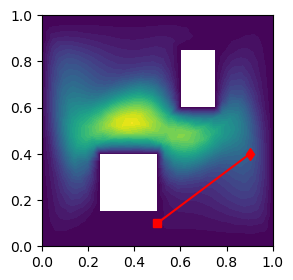

In [7]:
# user setting (for trying out different controls)
position = np.hstack(
            (np.linspace(0.5, 0.9, drone.grid_t.shape[0]), np.linspace(0.1, 0.4, drone.grid_t.shape[0]))
        )

# compute flight
flight = drone.plan_flight(alpha=position, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)


fig, ax = plt.subplots(1, 1, figsize = (3, 3))
fom.plot(state, ax=ax)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
plt.plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

### Circular path
Specify initial position, initial direction, velocity, and angular velocity. The interpretation of angular velocity feels a bit unintuitive to me, but I'm sure there are reasons for it.

In [8]:
from CircularPath import CircularPath as chosenPathClass

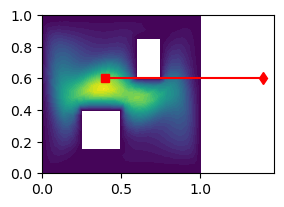

In [9]:
# user setting (for trying out different controls)
alpha = {
    "initial x" : 0.4,
    "initial y" : 0.6,
    "initial heading" : 0,
    "velocity" : 1,
    "angular velocity" : 1e-16,
}

# use path class to get position
path = chosenPathClass(alpha = alpha)
position = path.position(drone.grid_t)
position = np.hstack([position[:, 0], position[:, 1]])

# compute flight
flight = drone.plan_flight(alpha=position, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)


fig, ax = plt.subplots(1, 1, figsize = (3, 3))
fom.plot(state, ax=ax)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
plt.plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

In [10]:
deriv = path.d_position_d_angular_velocity(grid_t)

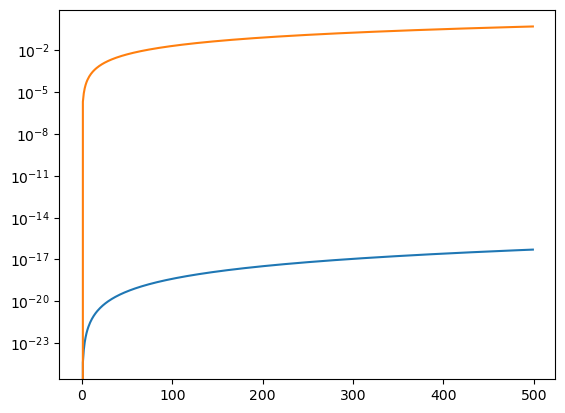

In [11]:
plt.semilogy(np.abs(deriv[:, 0]))
plt.plot(np.abs(deriv[:, 1]))

### CirclePath

This one is like `CircularPath` but uses a radius instead of angular velocity (which somehow also shifts the starting position), and the initial heading cannot be chosen. It uses a lot of the `CircularPath` functionality. I honestly find `CircularPath` easier to be used.

In [12]:
from CirclePath import CirclePath as chosenPathClass

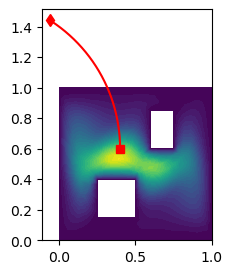

In [13]:
# user setting (for trying out different controls)
alpha = {
    "initial x" : 0.4,
    "initial y" : 0.6,
    "initial heading" : 0,
    "velocity" : 1,
    "radius" : 1
}

# use path class to get position
path = chosenPathClass(alpha = [alpha["radius"], 
                                alpha["velocity"]], 
                       center = [alpha["initial x"] - alpha["radius"]*np.cos(drone.grid_t[0]*2*np.pi), 
                                 alpha["initial y"] - alpha["radius"]*np.sin(drone.grid_t[0]*2*np.pi)])
position = path.position(drone.grid_t)
position = np.hstack([position[:, 0], position[:, 1]])

# compute flight
flight = drone.plan_flight(alpha=position, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)


fig, ax = plt.subplots(1, 1, figsize = (3, 3))
fom.plot(state, ax=ax)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
plt.plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

### Combined Circular Path

This one, honstly, is very fun. It's stacking different `CircularPaths` together, each one with its own velocity and angular velocity.

In [14]:
from CombinedCircularPath import CombinedCircularPath as chosenPathClass

In [15]:
initial_x = 0.4
initial_y = 0.6
initial_heading = 1
velocity_angularVelocity = [np.array([1, 0]), np.array([1, 5]), np.array([1, -5])]
transition_times = np.array([0, 0.25, 0.5, 1])

In [16]:
path = chosenPathClass(initial_x = initial_x, 
                       initial_y = initial_y, 
                       initial_heading = initial_heading, 
                       parameters = velocity_angularVelocity,
                       transition_times = transition_times)

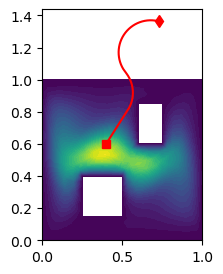

In [17]:
# use path class to get position
position = path.position(drone.grid_t)
position = np.hstack([position[:, 0], position[:, 1]])

# compute flight
flight = drone.plan_flight(alpha=position, grid_t=drone.grid_t)  # Flight object
flightpath, grid_t = flight.flightpath, flight.grid_t  # path and its time discretization

# measure data
data = drone.measure(flight=flight, state=state)


fig, ax = plt.subplots(1, 1, figsize = (3, 3))
fom.plot(state, ax=ax)
plt.plot(flightpath[:, 0], flightpath[:, 1], color="r")
plt.plot([flightpath[0, 0]], [flightpath[0, 1]], color="r", marker="s")
plt.plot([flightpath[-1, 0]], [flightpath[-1, 1]], color="r", marker="d")

I still find the angular velocity somewhat hard to wrap my head around, but it works, somehow. The only other thing I wish was there was the possibility to reset the heading direction at each transition time instead of having the path be continuous. This would allow to fly from point to point in straight lines. Maybe I can add that later.

In [18]:
deriv = path.d_position_d_initial_heading(t = grid_t)

In [19]:
deriv[400, :, :]

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
plt.plot(deriv[:, 0, 1])
plt.plot(deriv[:, 1, 1])
plt.plot(deriv[:, 2, 1])

In [ ]:
test = np.array([0, 1, 2])

In [ ]:
def my_test(test):
    a = test[0]
    a = 5

In [ ]:
my_test(test)

In [ ]:
test